In [1]:
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import count, when, col
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.sql.window import Window
from pyspark.mllib.stat import Statistics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import math
import numpy as np

In [2]:
def stratified_split(df, ratios: list=[0.8, 0.1, 0.1], target_col: str='label'):
  pos = df.filter(F.col(target_col)==1)
  neg = df.filter(F.col(target_col)==0)
  
  train_pos, valid_pos, test_pos = pos.randomSplit(ratios, seed=SEED)
  train_neg, valid_neg, test_neg = neg.randomSplit(ratios, seed=SEED)
  
  return train_pos.union(train_neg), valid_pos.union(valid_neg), test_pos.union(test_neg)


def calculate_profit(y_true, y_pred, transaction_amounts):
    total_profit = 0.0
    total_loss = 0.0
    
    # Iterar sobre todas as transações
    for true_label, pred_label, amount in zip(y_true, y_pred, transaction_amounts):
        if true_label == 0 and pred_label == 0:
            # Transação corretamente prevista sem chargeback - lucro de 15% do valor da transação
            total_profit += 0.15 * amount
        elif true_label == 1 and pred_label == 0:
            # Falso negativo (fraude não detectada) - perda total do valor da transação
            total_loss += amount
    
    net_profit = total_profit - total_loss
    return net_profit

In [3]:
SEED = 12345

**What is the problem?** 

Approved transactions may generate chargebacks (total loss of value) or not (generating 15% of revenue). The goal is to develop a solution to prevent chargebacks and maximize profitability.

**What is the specific objectives?**

- Develop a model to predict chargebacks on transactions.
- Compare the performance of the solution with the other two providers.
- Evaluate the solution based on appropriate methodologies.

In [ ]:
DATA_PATH = ""

In [4]:
# Create a Spark session
spark = SparkSession.builder.appName("Incognia Chargeback Analysis")\
    .getOrCreate()

24/10/07 18:45:23 WARN Utils: Your hostname, arthur-B760M-AORUS-ELITE resolves to a loopback address: 127.0.1.1; using 192.168.0.111 instead (on interface wlx90de801597dc)
24/10/07 18:45:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 18:45:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/07 18:45:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/07 18:45:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/07 18:45:24 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [5]:
raw_data = spark.read.parquet(DATA_PATH)
raw_data = raw_data.withColumn("chargeback", col("chargeback").cast(StringType()))

In [6]:
# As said in the document, we can assume that all transactions were approved.
raw_data = raw_data.drop("status")

In [7]:
original_categorical_features = ['id', 'device_id', 'account_id', 'installation_id', 'f_os', 'chargeback', 'provider']
original_numerical_features = [
    'total_amount', 'f_boot_count', 'f_wallpaper_id', 'f_chargeback_rate_by_geohash_5_30d', 'f_chargeback_rate_by_geohash_6_30d', 
    'f_chargeback_rate_by_geohash_7_30d', 'f_sum_values_by_ilm_id_30d', 'f_sum_values_by_ilm_id_3d', 'f_device_age_ms', 'f_account_age_ms',
    'f_sum_values_by_device_id_30d', 'f_sum_values_by_device_id_3d', 'f_n_user_ids_by_device_id_30d', 'f_n_installations_by_device_id_30d',
    'f_total_events', 'f_total_installations', 'f_total_fraud_installations', 'f_total_fraud_events', 'f_avg_fraud_installations', 'f_avg_fraud_events'
]
original_timestamp_features = ["dt", "timestamp"]

# Data Cleaning

In [8]:
def check_missing_values(data) -> dict:
    missing_values = {} 

    for index, column in enumerate(data.columns):
        missing_count = data.filter(col(column).isNull()).count()
        missing_values.update({column: missing_count / data.count()})
    
    return missing_values

In [9]:
missing_values = check_missing_values(raw_data)

In [10]:
missing_values

{'dt': 0.0,
 'id': 0.0,
 'device_id': 0.0,
 'account_id': 0.0,
 'installation_id': 0.0,
 'timestamp': 0.0,
 'total_amount': 0.0,
 'f_boot_count': 0.37978619432694233,
 'f_wallpaper_id': 0.3797887099837614,
 'f_chargeback_rate_by_geohash_5_30d': 0.11829247277744864,
 'f_chargeback_rate_by_geohash_6_30d': 0.11923835974144079,
 'f_chargeback_rate_by_geohash_7_30d': 0.13286064141701917,
 'f_sum_values_by_ilm_id_30d': 0.711396302739173,
 'f_sum_values_by_ilm_id_3d': 0.7114227171357738,
 'f_device_age_ms': 0.0,
 'f_account_age_ms': 0.0,
 'f_os': 0.0,
 'f_sum_values_by_device_id_30d': 0.65309721378429,
 'f_sum_values_by_device_id_3d': 0.6531009872695187,
 'f_n_user_ids_by_device_id_30d': 0.18699002919419738,
 'f_n_installations_by_device_id_30d': 0.18682273801572538,
 'f_total_events': 0.5338412444451153,
 'f_total_installations': 0.5338412444451153,
 'f_total_fraud_installations': 0.5338412444451153,
 'f_total_fraud_events': 0.5338412444451153,
 'f_avg_fraud_installations': 0.533841244445115

<Axes: >

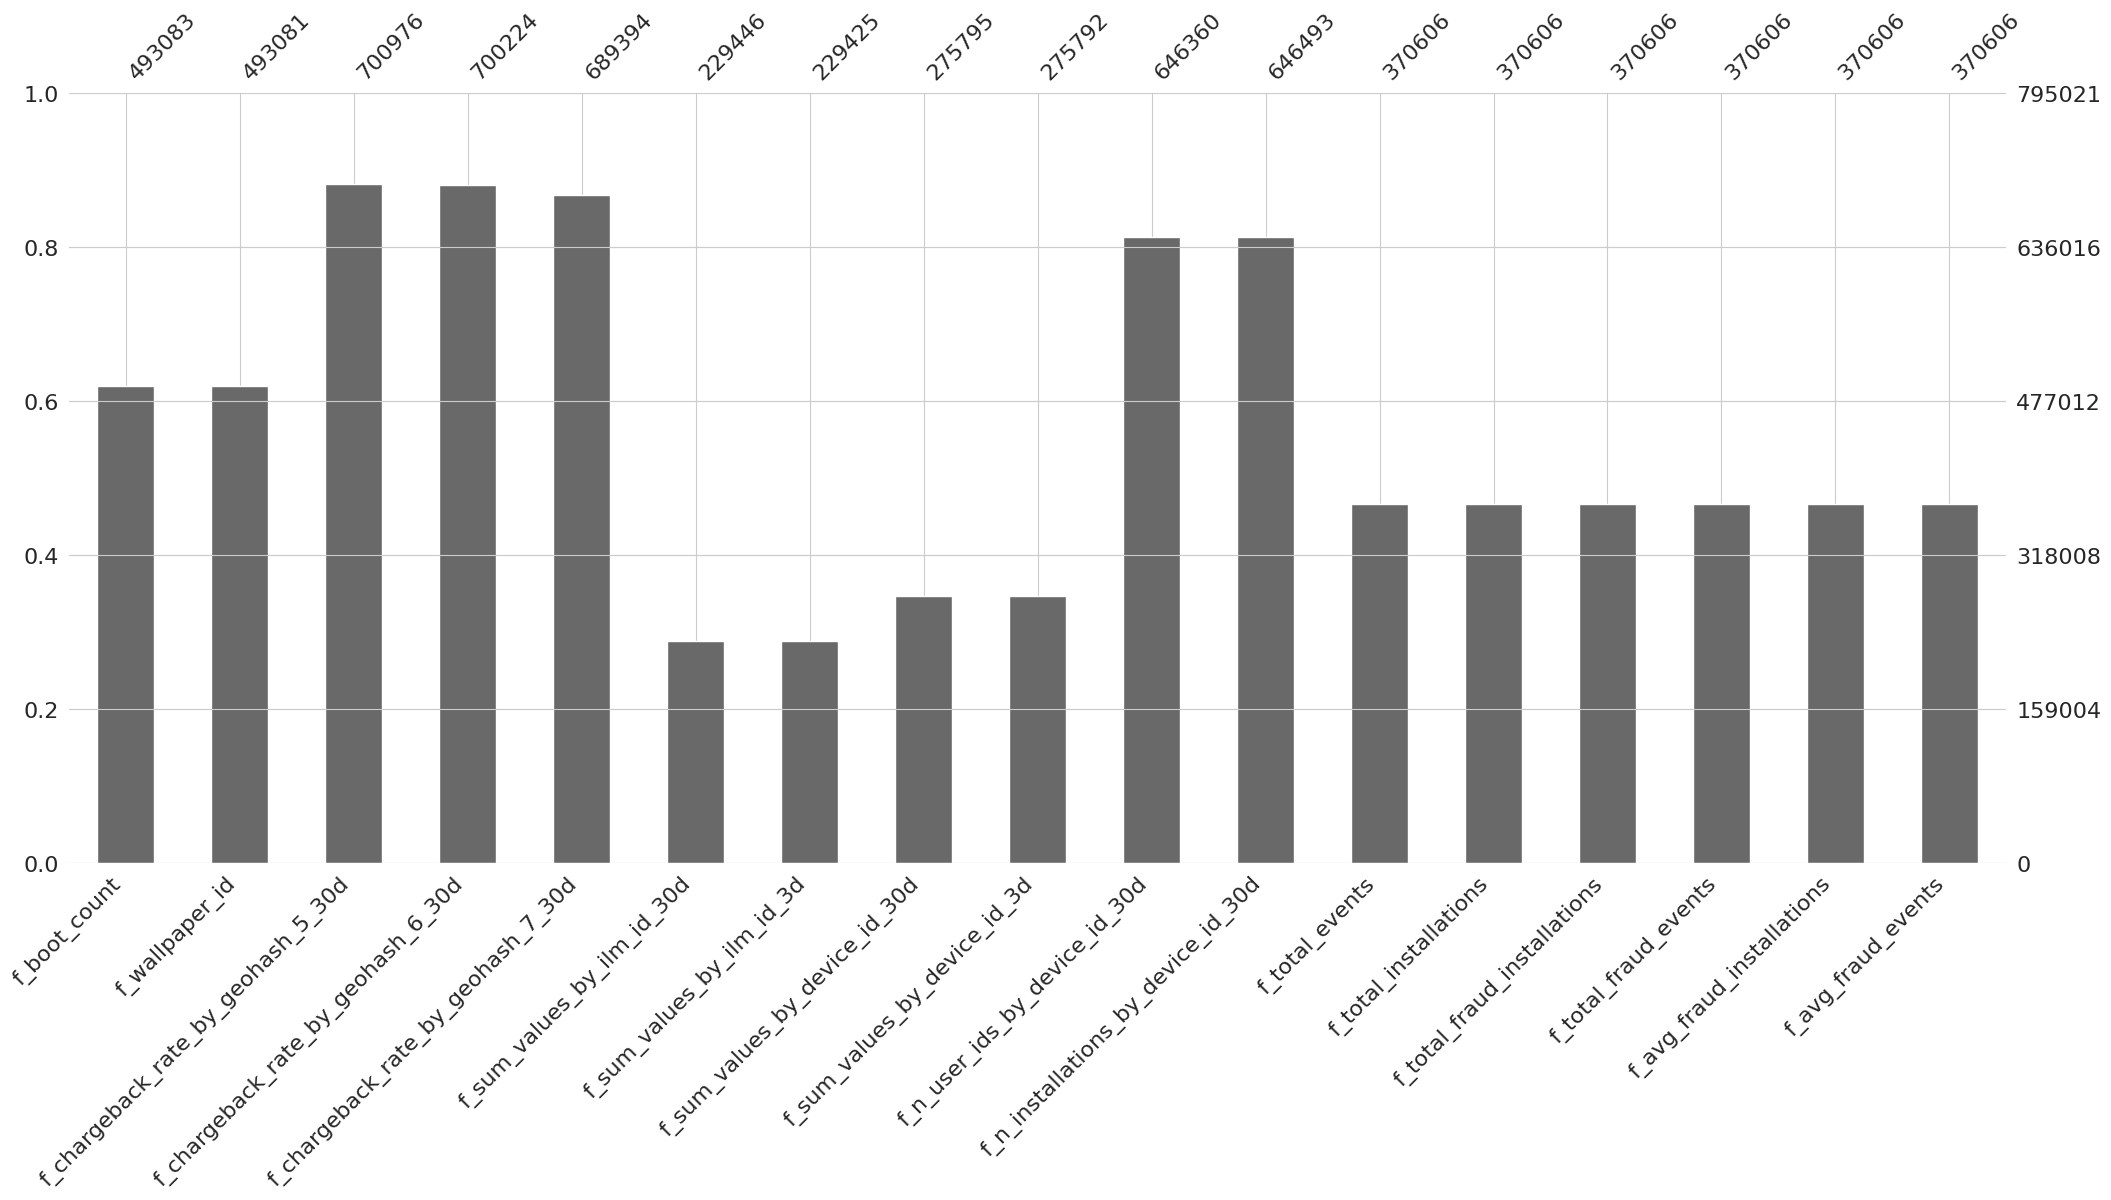

In [11]:
import missingno as msno


missing_columns = [column for column, value in missing_values.items() if value > 0]
missing_data_pd = raw_data.select(missing_columns).toPandas()
msno.bar(missing_data_pd)

- Features like `dt`, `id`, `device_id`, `account_id`, `installation_id`, `timestamp`, `total_amount`, `f_device_age_ms`, `f_account_age_ms`, `f_os`, and `provider` show no missing values.
- `f_boot_count` and `f_wallpaper_id` have about 38% missing values.
- Geographic features such as `f_chargeback_rate_by_geohash_5_30d`, `f_chargeback_rate_by_geohash_6_30d`, and `f_chargeback_rate_by_geohash_7_30d` show approximately 87-88% non-null values, meaning that around 12-13% of the data is missing for these features.
- `f_n_user_ids_by_device_id_30d` and `f_n_installations_by_device_id_30d` both show roughly 81-82% non-null values.

**Significant Missing Data:**
- Features like `f_sum_values_by_ilm_id_30d`, `f_sum_values_by_ilm_id_3d`, `f_sum_values_by_device_id_30d`, and `f_sum_values_by_device_id_3d` exhibit a high proportion of missing data, with around 65-71% of their values absent.
- Features related to fraud detection, such as `f_total_events`, `f_total_installations`, `f_total_fraud_installations`, `f_total_fraud_events`, `f_avg_fraud_installations`, and `f_avg_fraud_events`, have nearly 53% null values.

<Axes: >

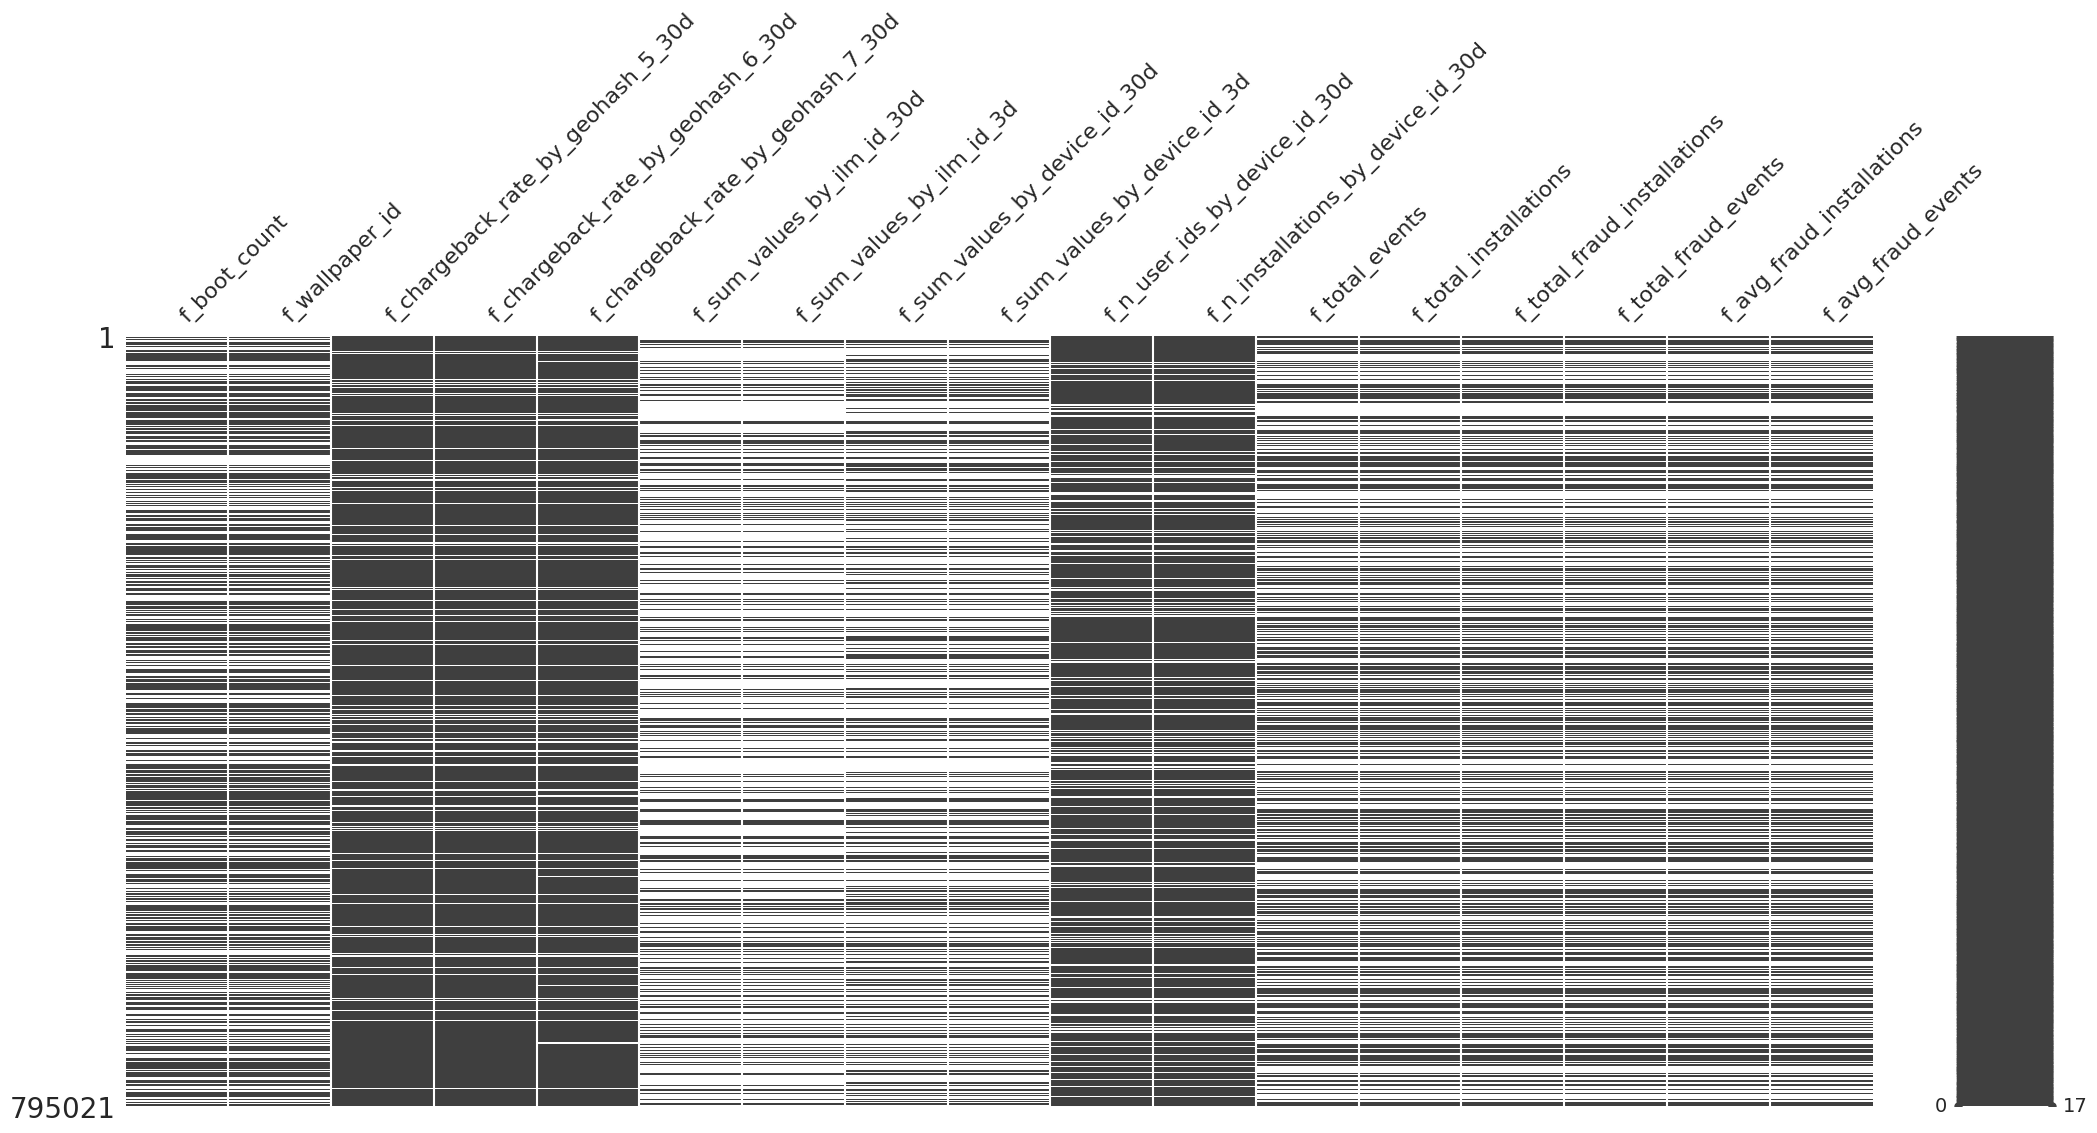

In [12]:
msno.matrix(missing_data_pd)

<Axes: >

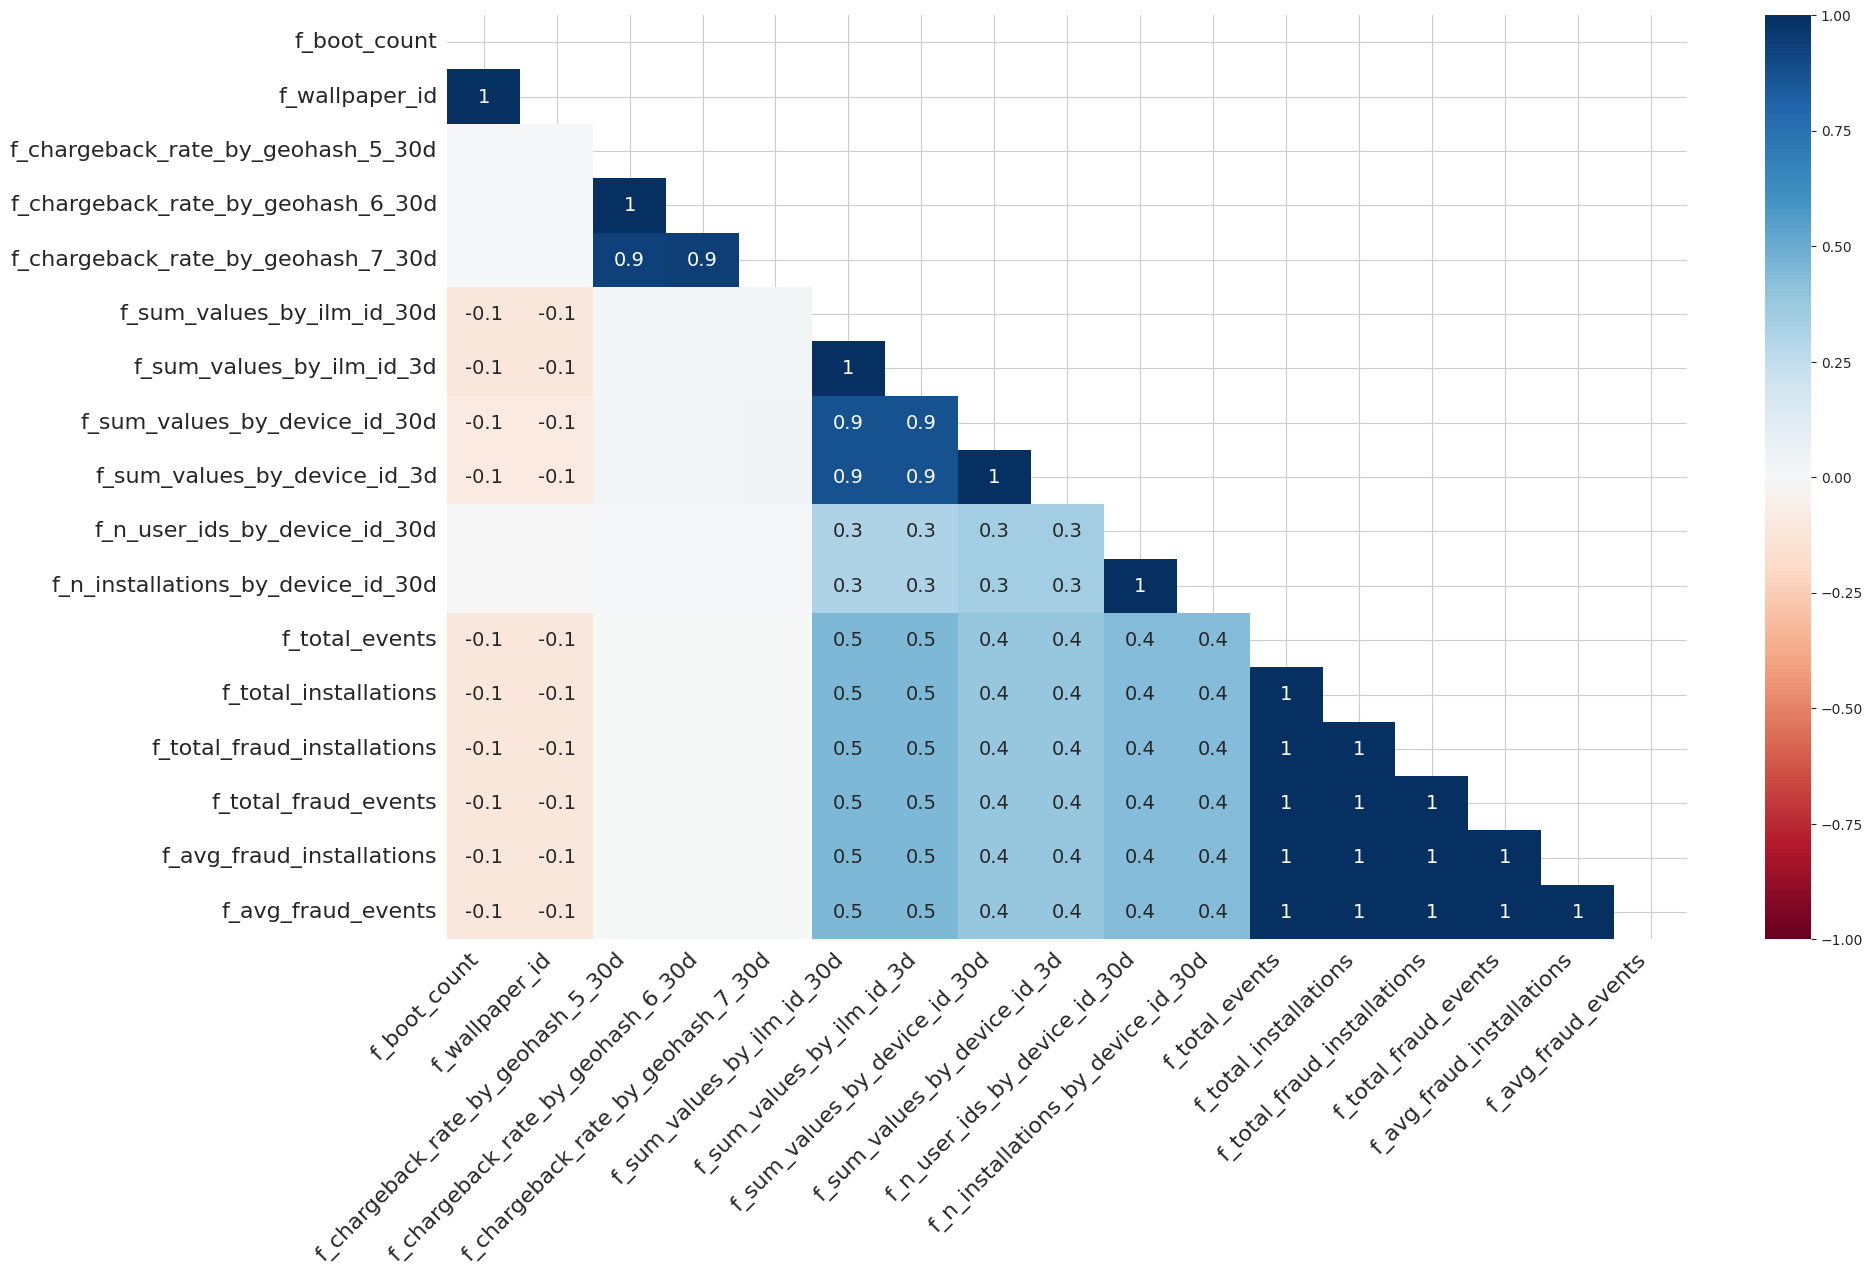

In [13]:
msno.heatmap(missing_data_pd)

The figures above provides a visual representation of the missing data patterns across the dataset's features.

- The fraud-related features (`f_total_fraud_installations`, `f_total_fraud_events`, `f_avg_fraud_installations`, `f_avg_fraud_events`) have perfect correlations (1.0) with each other. This means that whenever one of these columns has missing values, the others will also have missing values (MNAR).
- Similarly, there is a high correlation between f_sum_values_by_device_id_30d and f_sum_values_by_device_id_3d, indicating that the missing values in these features often occur together.
- The features representing geographic chargeback rates (`f_chargeback_rate_by_geohash_5_30d`, `f_chargeback_rate_by_geohash_6_30d`, `f_chargeback_rate_by_geohash_7_30d`) also exhibit strong correlations in their missing values (around 0.9).
- Some moderate correlations (around 0.3 to 0.5) exist between missing values in `f_n_user_ids_by_device_id_30d`, `f_n_installations_by_device_id_30d`, and some fraud-related features like `f_total_events` and `f_total_installations`. This implies that, although not perfectly, missing values in one set of features (related to device IDs) are somewhat associated with missing values in fraud-related features.
- Some of the features, such as `f_boot_count` and `f_wallpaper_id`, show very low correlations with missing values in other columns. This suggests that their missing values are likely independent and do not follow the same pattern as other features (MCAR).

In [17]:
cleaned_data = raw_data.alias("cleaned_data")

### Group-Based Imputation (Features with over 50% Missing)

These features have high missingness and need to be imputed based on their provider group:

- f_sum_values_by_ilm_id_30d (71%)
- f_sum_values_by_ilm_id_3d (71%)
- f_sum_values_by_device_id_30d (65%)
- f_sum_values_by_device_id_3d (65%)
- f_total_events, f_total_installations, f_total_fraud_installations, f_total_fraud_events, f_avg_fraud_installations, f_avg_fraud_events (53%)

In [19]:
# Define window to partition by provider
window = Window.partitionBy("provider")

# Impute missing fraud events by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_fraud_events_imputed",
    F.when(F.col("f_total_fraud_events").isNull(), 
           F.avg("f_total_fraud_events").over(window)).otherwise(F.col("f_total_fraud_events"))
)

# Impute missing fraud events by provider
cleaned_data = cleaned_data.withColumn(
    "f_total_fraud_installations_imputed",
    F.when(F.col("f_total_fraud_installations").isNull(), 
           F.avg("f_total_fraud_installations").over(window)).otherwise(F.col("f_total_fraud_installations"))
)

# Impute missing sum values by ilm id by provider
cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_ilm_id_30d_imputed",
    F.when(F.col("f_sum_values_by_ilm_id_30d").isNull(), 
           F.avg("f_sum_values_by_ilm_id_30d").over(window)).otherwise(F.col("f_sum_values_by_ilm_id_30d"))
)

# Impute missing sum values by ilm id by provider
cleaned_data = cleaned_data.withColumn(
    "f_sum_values_by_device_id_30d_imputed",
    F.when(F.col("f_sum_values_by_device_id_30d").isNull(), 
           F.avg("f_sum_values_by_device_id_30d").over(window)).otherwise(F.col("f_sum_values_by_device_id_30d"))
)

### Median/Mean Imputation (Features with 10-50% Missing)

In [20]:
# Median imputation for f_boot_count
median_boot_count = cleaned_data.approxQuantile("f_boot_count", [0.5], 0.01)[0]
cleaned_data = cleaned_data.fillna({"f_boot_count": median_boot_count})

# Median imputation for f_wallpaper_id
median_wallpaper_id = cleaned_data.approxQuantile("f_wallpaper_id", [0.5], 0.01)[0]
cleaned_data = cleaned_data.fillna({"f_wallpaper_id": median_wallpaper_id})

# Median imputation for chargeback rates by geohash levels
median_chargeback_geohash_5 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_5_30d", [0.5], 0.01)[0]
median_chargeback_geohash_6 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_6_30d", [0.5], 0.01)[0]
median_chargeback_geohash_7 = cleaned_data.approxQuantile("f_chargeback_rate_by_geohash_7_30d", [0.5], 0.01)[0]

cleaned_data = cleaned_data.fillna({
    "f_chargeback_rate_by_geohash_5_30d": median_chargeback_geohash_5,
    "f_chargeback_rate_by_geohash_6_30d": median_chargeback_geohash_6,
    "f_chargeback_rate_by_geohash_7_30d": median_chargeback_geohash_7
})

# Median imputation for device-related features
median_n_user_ids = cleaned_data.approxQuantile("f_n_user_ids_by_device_id_30d", [0.5], 0.01)[0]
median_n_installations = cleaned_data.approxQuantile("f_n_installations_by_device_id_30d", [0.5], 0.01)[0]

cleaned_data = cleaned_data.fillna({
    "f_n_user_ids_by_device_id_30d": median_n_user_ids,
    "f_n_installations_by_device_id_30d": median_n_installations
})

# Feature Engineering

In [8]:
data = raw_data.alias("data")

In [9]:
indexer_chargeback = StringIndexer(inputCol="chargeback", outputCol="label")
data = indexer_chargeback.fit(data).transform(data)

In [15]:
def check_multicollinearity(df, feature_cols):
    corr_data = df.select(feature_cols)
    # Convert the selected features into an RDD format (Resilient Distributed Dataset)
    features = corr_data.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(features, method="spearman")

    corr_matrix_df = pd.DataFrame(data=corr_mat, columns=feature_cols, index=feature_cols)
    return corr_matrix_df

### Temporal Features:

In [10]:
def create_temporal_features(data):
    data = data.withColumn('day_of_week', F.dayofweek('dt'))
    data = data.withColumn('day_of_month', F.dayofmonth('dt'))
    data = data.withColumn('month', F.month('dt'))
    data = data.withColumn('season', when((data.month >= 3) & (data.month <= 5), 'Spring')
                            .when((data.month >= 6) & (data.month <= 8), 'Summer')
                            .when((data.month >= 9) & (data.month <= 11), 'Autumn')
                            .otherwise('Winter'))

    data = data.withColumn('seconds_from_midnight', F.unix_timestamp('timestamp') % 86400)
    data = data.withColumn('hour_of_day', F.hour('timestamp'))
    data = data.withColumn(
        'day_period', 
        when((data['hour_of_day'] >= 0) & (data['hour_of_day'] < 6), 'Madrugada')
        .when((data['hour_of_day'] >= 6) & (data['hour_of_day'] < 12), 'Manhã')
        .when((data['hour_of_day'] >= 12) & (data['hour_of_day'] < 18), 'Tarde')
        .otherwise('Noite')
    )
    return data

In [24]:
data = create_temporal_features(data)

In [25]:
numeric_cols = ['hour_of_day', 'seconds_from_midnight', 'day_of_week', 'day_of_month', 'month', 'label']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_vector = assembler.transform(data).select("corr_features")

pearson_corr = Correlation.corr(df_vector, "corr_features", "pearson").head()[0]
pearson_corr_df = pd.DataFrame(pearson_corr.toArray(), index=numeric_cols, columns=numeric_cols)
print("Pearson Correlation Matrix for Numerical Variables:\n")
pearson_corr_df

Matriz de Correlação de Pearson para as Variáveis Numéricas:



,hour_of_day,seconds_from_midnight,day_of_week,day_of_month,month,label
hour_of_day,1.000000,-0.071401,0.003508,-0.005952,0.004662,-0.028817
seconds_from_midnight,-0.071401,1.000000,0.032103,-0.000683,0.000567,-0.021052
day_of_week,0.003508,0.032103,1.000000,-0.035782,-0.007810,0.001011
day_of_month,-0.005952,-0.000683,-0.035782,1.000000,-0.198031,0.002753
month,0.004662,0.000567,-0.007810,-0.198031,1.000000,-0.026933
label,-0.028817,-0.021052,0.001011,0.002753,-0.026933,1.000000


In [26]:
from pyspark.ml.stat import ChiSquareTest

indexer_day_period = StringIndexer(inputCol='day_period', outputCol='day_period_indexed')
indexer_season = StringIndexer(inputCol='season', outputCol='season_indexed')

data = indexer_day_period.fit(data).transform(data)
data = indexer_season.fit(data).transform(data)

assembler_day_period = VectorAssembler(inputCols=['day_period_indexed'], outputCol='features')
df_day_period_assembled = assembler_day_period.transform(data)

chi_square_day_period = ChiSquareTest.test(df_day_period_assembled, 'features', 'label').head()
print("Resultados do Teste Qui-Quadrado para 'day_period':\n", chi_square_day_period)

assembler_season = VectorAssembler(inputCols=['season_indexed'], outputCol='features')
df_season_assembled = assembler_season.transform(data)

chi_square_season = ChiSquareTest.test(df_season_assembled, 'features', 'label').head()
print("Resultados do Teste Qui-Quadrado para 'season':\n", chi_square_season)

Resultados do Teste Qui-Quadrado para 'day_period':
 Row(pValues=DenseVector([0.0]), degreesOfFreedom=[3], statistics=DenseVector([1216.696]))
Resultados do Teste Qui-Quadrado para 'season':
 Row(pValues=DenseVector([0.0]), degreesOfFreedom=[1], statistics=DenseVector([220.6753]))


Since the p-value is less than 0.05, it means that there is strong evidence that there is a significant association between the two variables. This could tell us that the season of the year has some effect on whether or not transactions result in chargebacks.

### Historical Counts

- Transaction Frequency by Device: How many transactions occurred in a given period per device (3, 7, 30 days).

In [13]:
def create_transaction_counts(df):
    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-30 * 86400, 0)
    df = df.withColumn("transaction_count_last_30_days", F.count("id").over(window_spec))
    return df

In [64]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-3 * 86400, 0)
data = data.withColumn("transaction_count_last_3_days", F.count("id").over(window_spec))

In [65]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-7 * 86400, 0)
data = data.withColumn("transaction_count_last_7_days", F.count("id").over(window_spec))

In [66]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-30 * 86400, 0)
data = data.withColumn("transaction_count_last_30_days", F.count("id").over(window_spec))

In [67]:
check_multicollinearity(data, ["transaction_count_last_3_days", "transaction_count_last_7_days", "transaction_count_last_30_days", "label"])

24/10/07 14:49:12 WARN Executor: Managed memory leak detected; size = 5245400 bytes, task 0.0 in stage 342.0 (TID 2419)
24/10/07 14:49:13 WARN Executor: Managed memory leak detected; size = 5245400 bytes, task 0.0 in stage 351.0 (TID 2441)


,transaction_count_last_3_days,transaction_count_last_7_days,transaction_count_last_30_days,label
transaction_count_last_3_days,1.000000,0.914902,0.822354,0.165027
transaction_count_last_7_days,0.914902,1.000000,0.900944,0.168802
transaction_count_last_30_days,0.822354,0.900944,1.000000,0.169521
label,0.165027,0.168802,0.169521,1.000000


### Temporal Aggregations
- Sum of transaction amounts in the last 3/7/30 days: Calculating the sum of recent transaction amounts can capture anomalous patterns.
- Standard deviation of transaction amount: Variability in recent transactions can be indicative of suspicious behavior.

In [15]:
def create_temporal_aggregations(df):
    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-30 * 86400, 0)
    df = df.withColumn("sum_values_last_30d", F.sum("total_amount").over(window_spec))

    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-7 * 86400, 0)
    df = df.withColumn("transaction_count_last_30_days", F.count("id").over(window_spec))
    return df

In [11]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-3 * 86400, 0)
data = data.withColumn("sum_values_last_3d", F.sum("total_amount").over(window_spec))
data = data.withColumn("stddev_values_last_3d", F.stddev("total_amount").over(window_spec))

In [22]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-7 * 86400, 0)
data = data.withColumn("sum_values_last_7d", F.sum("total_amount").over(window_spec))
data = data.withColumn("stddev_values_last_7d", F.stddev("total_amount").over(window_spec))

In [23]:
window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-30 * 86400, 0)
data = data.withColumn("sum_values_last_30d", F.sum("total_amount").over(window_spec))
data = data.withColumn("stddev_values_last_30d", F.stddev("total_amount").over(window_spec))

In [26]:
check_multicollinearity(data, ["sum_values_last_3d", "sum_values_last_7d", "sum_values_last_30d", "label"])

24/10/07 15:50:06 WARN Executor: Managed memory leak detected; size = 5243066 bytes, task 0.0 in stage 193.0 (TID 1401)
24/10/07 15:50:07 WARN Executor: Managed memory leak detected; size = 5243066 bytes, task 0.0 in stage 202.0 (TID 1423)


,sum_values_last_3d,sum_values_last_7d,sum_values_last_30d,label
sum_values_last_3d,1.000000,0.992661,0.982042,0.114851
sum_values_last_7d,0.992661,1.000000,0.990542,0.119583
sum_values_last_30d,0.982042,0.990542,1.000000,0.124210
label,0.114851,0.119583,0.124210,1.000000


Based on the correlations, we can make the following decisions:

- Keep:
    - sum_values_last_7d: Captures the sum of transaction values ​​in the last 7 days and has a moderate correlation with the label.
    - transaction_count_last_7_days: The feature with the highest positive correlation with the label and without high multicollinearity with other features.
    - stddev_values_last_7d: Although it has a weak correlation with the label, it captures a distinct behavior related to transaction variability, which can be useful.

- Remove:
    - total_amount: It has a high correlation with sum_values_last_7d, which indicates redundancy. Since sum_values_last_7d aggregates more information, we can remove total_amount to avoid multicollinearity.

### Device and Account Age-Related Features

In [29]:
# Device age in days
data = data.withColumn('device_age_days', F.col('f_device_age_ms') / (1000 * 60 * 60 * 24))

# Account age in days
data = data.withColumn('account_age_days', F.col('f_account_age_ms') / (1000 * 60 * 60 * 24))

# Ratio of total amount to device age
data = data.withColumn('amount_to_device_age_ratio', F.col('total_amount') / F.col('device_age_days'))

In [30]:
check_multicollinearity(data, ["device_age_days", "account_age_days", "amount_to_device_age_ratio", "label"])

24/10/07 15:39:54 WARN Executor: Managed memory leak detected; size = 15769734 bytes, task 0.0 in stage 225.0 (TID 1634)
24/10/07 15:39:54 WARN Executor: Managed memory leak detected; size = 16104732 bytes, task 2.0 in stage 225.0 (TID 1635)
24/10/07 15:39:55 WARN Executor: Managed memory leak detected; size = 16104732 bytes, task 2.0 in stage 235.0 (TID 1661)
24/10/07 15:39:55 WARN Executor: Managed memory leak detected; size = 15769734 bytes, task 0.0 in stage 235.0 (TID 1660)


,device_age_days,account_age_days,amount_to_device_age_ratio,label
device_age_days,1.000000,0.790647,-0.935046,0.043560
account_age_days,0.790647,1.000000,-0.726035,0.054707
amount_to_device_age_ratio,-0.935046,-0.726035,1.000000,-0.017985
label,0.043560,0.054707,-0.017985,1.000000


In [31]:
# Bucketing device age into categories
data = data.withColumn('device_age_group', 
                   F.when(F.col('device_age_days') <= 30, 0)
                    .when((F.col('device_age_days') > 30) & (F.col('device_age_days') <= 365), 1)
                    .otherwise(2))
    
indexer = StringIndexer(inputCol="device_age_group", outputCol="device_age_group_index")
encoder = OneHotEncoder(inputCol="device_age_group_index", outputCol="device_age_group_encoded")
pipeline = Pipeline(stages=[indexer, encoder])
pipeline_model = pipeline.fit(data)
data = pipeline_model.transform(data)

In [32]:
# Bucketing account age into categories
data = data.withColumn('account_age_group', 
                   F.when(F.col('account_age_days') <= 30, 'New')
                    .when((F.col('account_age_days') > 30) & (F.col('account_age_days') <= 365), 'Medium')
                    .otherwise('Old'))

### Geohash features

In [12]:
def impute_geohash_features_with_median(df):
    for col_name in ['f_chargeback_rate_by_geohash_5_30d', 'f_chargeback_rate_by_geohash_6_30d', 'f_chargeback_rate_by_geohash_7_30d']:
        median_value = df.stat.approxQuantile(col_name, [0.5], 0.01)[0]
        df = df.withColumn(col_name, F.when(F.col(col_name).isNull(), median_value).otherwise(F.col(col_name)))
    
    return df

def impute_geohash_features_with_special_category(df):
    for col_name in ['f_chargeback_rate_by_geohash_5_30d', 'f_chargeback_rate_by_geohash_6_30d', 'f_chargeback_rate_by_geohash_7_30d']:
        df = df.withColumn(col_name, F.when(F.col(col_name).isNull(), -1).otherwise(F.col(col_name)))
    
    return df

In [34]:
data = impute_geohash_features_with_median(data)

In [13]:
def create_geographic_features(df):
    df = df.withColumn('mean_chargeback_rate', 
                       (F.col('f_chargeback_rate_by_geohash_5_30d') + 
                        F.col('f_chargeback_rate_by_geohash_6_30d') + 
                        F.col('f_chargeback_rate_by_geohash_7_30d')) / 3)
    
    df = df.withColumn('difference_high_low_geohash', 
                       F.abs(F.col('f_chargeback_rate_by_geohash_7_30d') - F.col('f_chargeback_rate_by_geohash_5_30d')))

    
    return df

In [505]:
data = create_geographic_features(data)

In [473]:
check_multicollinearity(data, ["mean_chargeback_rate", "difference_high_low_geohash", "f_chargeback_rate_by_geohash_5_30d", "f_chargeback_rate_by_geohash_6_30d", "f_chargeback_rate_by_geohash_7_30d", "label"])

24/10/05 17:56:19 WARN Executor: Managed memory leak detected; size = 38794120 bytes, task 2.0 in stage 699.0 (TID 5442)
24/10/05 17:56:19 WARN Executor: Managed memory leak detected; size = 36735972 bytes, task 0.0 in stage 699.0 (TID 5441)
24/10/05 17:56:20 WARN Executor: Managed memory leak detected; size = 36735972 bytes, task 0.0 in stage 709.0 (TID 5467)
24/10/05 17:56:20 WARN Executor: Managed memory leak detected; size = 38794120 bytes, task 2.0 in stage 709.0 (TID 5468)


,mean_chargeback_rate,difference_high_low_geohash,f_chargeback_rate_by_geohash_5_30d,f_chargeback_rate_by_geohash_6_30d,f_chargeback_rate_by_geohash_7_30d,label
mean_chargeback_rate,1.000000,0.895955,0.872916,0.644464,0.250521,0.053480
difference_high_low_geohash,0.895955,1.000000,0.973615,0.336332,0.225461,0.055206
f_chargeback_rate_by_geohash_5_30d,0.872916,0.973615,1.000000,0.304424,0.072830,0.052240
f_chargeback_rate_by_geohash_6_30d,0.644464,0.336332,0.304424,1.000000,0.255987,0.032626
f_chargeback_rate_by_geohash_7_30d,0.250521,0.225461,0.072830,0.255987,1.000000,0.031855
label,0.053480,0.055206,0.052240,0.032626,0.031855,1.000000


Final Feature Decisions:

- Remove:
    - difference_high_low_geohash: The correlation with other features is extremely high (0.895 and 0.973 with mean_chargeback_rate and f_chargeback_rate_by_geohash_5_30d, respectively). This feature is redundant.
    - f_chargeback_rate_by_geohash_7_30d: It has a very low correlation with the label (0.031) and a moderate correlation with other geographic features, which suggests that its impact may be limited.

- Keep:
    - mean_chargeback_rate: Summing up the chargeback rates of the three accuracies, this feature has a slightly higher correlation with the label (0.053) and captures useful information.

In [17]:
numerical_cols = ['mean_chargeback_rate', 'hour_of_day', 'seconds_from_midnight', 'day_of_week', 'day_of_month', 'month', 'transaction_count_last_30_days', 'sum_values_last_30d']
categorical_cols = ['day_period', 'season']

In [18]:
def feature_preparation(df, numerical_cols, categorical_cols, label_col, total_amount_col):
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=SEED)

    train_data_amounts = train_data.select(total_amount_col)
    test_data_amounts = test_data.select(total_amount_col)
    
    train_data = train_data.drop(total_amount_col)
    test_data = test_data.drop(total_amount_col)

    stages = []
    for col in categorical_cols:
        indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
        stages.append(indexer)
    
    assembler_numeric = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
    scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
    stages += [assembler_numeric, scaler]

    feature_cols = [f"{col}_indexed" for col in categorical_cols] + ["scaled_numerical_features"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    stages.append(assembler)

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(train_data)

    train_data_transformed = pipeline_model.transform(train_data)
    test_data_transformed = pipeline_model.transform(test_data)
    return train_data_transformed, test_data_transformed, train_data_amounts, test_data_amounts


In [19]:
train_data, test_data, _, test_data_amounts = feature_preparation(data, numerical_cols, categorical_cols, "label", "total_amount")

24/10/07 16:35:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [25]:
transaction_amounts = test_data_amounts.toPandas().values.ravel()

In [26]:
features_to_train = numerical_cols + categorical_cols

Generally, in tree-based models the scale of the features does not matter. This is because at each tree level, the score of a possible split will be equal whether the respective feature has been scaled or not.

# Model Training

In [27]:
def extract_features_from_vector(df, selected_features):
    feature_columns = pd.DataFrame(df['features'].tolist(), columns=selected_features)
    df_with_features = pd.concat([df, feature_columns], axis=1)
    df_with_features = df_with_features.drop(columns=['features'])
    return df_with_features

In [28]:
X_train = train_data.select("features").toPandas()
X_train = extract_features_from_vector(X_train, features_to_train)

y_train = train_data.select("label").toPandas().values.ravel()

In [29]:
X_test = test_data.select("features").toPandas()
X_test = extract_features_from_vector(X_test, features_to_train)

y_test = test_data.select("label").toPandas().values.ravel()

In [30]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, fbeta_score, precision_score, recall_score

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F1 Score: {f1}\n")
    print(f"F2 Score {f2}")
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

In [45]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [49]:
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': rf_model.feature_names_in_, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                          Feature  Gini Importance
4                    day_of_month         0.256058
9                          season         0.249544
2           seconds_from_midnight         0.225971
6  transaction_count_last_30_days         0.093064
5                           month         0.049207
3                     day_of_week         0.046227
8                      day_period         0.046113
7             sum_values_last_30d         0.020786
0            mean_chargeback_rate         0.008403
1                     hour_of_day         0.004626


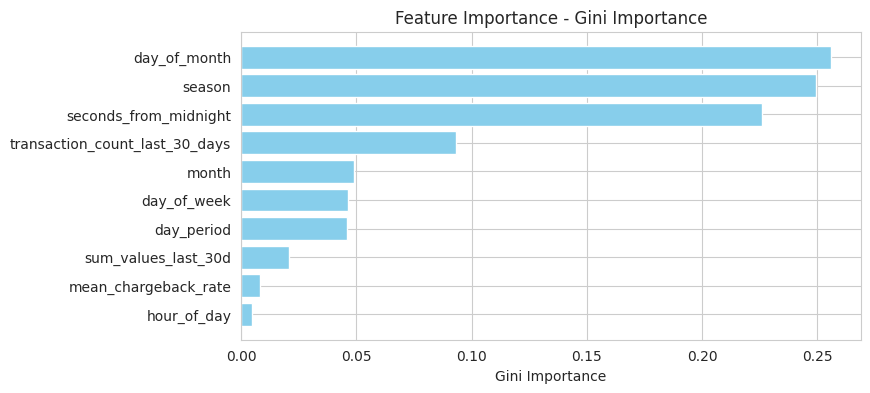

In [51]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_imp_df["Feature"], feature_imp_df["Gini Importance"], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

## LightGBM

In [52]:
from lightgbm import LGBMClassifier


def train_lgbm(X_train, y_train, X_test, y_test, transaction_amounts, threshold=0.5):
    model = LGBMClassifier(is_unbalance=True)
    model.fit(X_train, y_train)
    
    probas = model.predict_proba(X_test)[:, 1]
    
    y_pred_thresholded = (probas >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_thresholded)
    tn, fp, fn, tp = cm.ravel()

    precision = precision_score(y_test, y_pred_thresholded)
    recall = recall_score(y_test, y_pred_thresholded)
    f1 = f1_score(y_test, y_pred_thresholded)
    

    net_profit = calculate_profit(y_test, y_pred_thresholded, transaction_amounts)
    
    metrics = {
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "Precision": precision,
        "Recall": recall,
        "Profit": net_profit,
        "Threshold": threshold
    }
    
    return metrics, y_pred_thresholded

def optimize_threshold(X_train, y_train, X_test, y_test, transaction_amounts, thresholds=np.arange(0.1, 1.0, 0.05)):
    best_metrics = None
    best_threshold = None
    max_net_profit = float('-inf')
    
    for threshold in thresholds:
        metrics, _ = train_lgbm(X_train, y_train, X_test, y_test, transaction_amounts, threshold=threshold)
        
        if metrics["Profit"] > max_net_profit:
            max_net_profit = metrics["Profit"]
            best_metrics = metrics
            best_threshold = threshold
    
    return best_threshold, best_metrics

In [53]:
best_th, best_metrics = optimize_threshold(X_train, y_train, X_test, y_test, test_data_amounts.toPandas().values.ravel())

[LightGBM] [Info] Number of positive: 14534, number of negative: 621149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 635683, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022864 -> initscore=-3.755080
[LightGBM] [Info] Start training from score -3.755080
[LightGBM] [Info] Number of positive: 14534, number of negative: 621149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 635683, number of used features: 10
[LightGBM] [Info

In [63]:
metrics 

{'True Positives (TP)': np.int64(615),
 'True Negatives (TN)': np.int64(152913),
 'False Positives (FP)': np.int64(2875),
 'False Negatives (FN)': np.int64(2935),
 'Precision': np.float64(0.17621776504297995),
 'Recall': np.float64(0.1732394366197183),
 'Profit': np.float32(870305.06),
 'Threshold': np.float64(0.8500000000000002)}

In [57]:
# Assuming your data contains a 'provider' column with values: 'EXTERNAL_1', 'EXTERNAL_2', 'YOU'
data_external_1 = test_data.filter(F.col("provider") == "EXTERNAL_1")
data_external_2 = test_data.filter(F.col("provider") == "EXTERNAL_2")
data_you = test_data.filter(F.col("provider") == "YOU")

In [58]:
# Group by provider and chargeback, and count the occurrences
chargeback_by_provider_df = raw_data.groupBy("provider").count().toPandas()

# Pivot the data for stacked bar plotting
chargeback_by_provider_pivot = chargeback_by_provider_df.pivot(index='provider', columns='chargeback', values='count')

# Plot stacked bar
chargeback_by_provider_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Chargeback Distribution by Provider')
plt.xlabel('Provider')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=0)
plt.legend(title='Chargeback')
plt.show()

109182

## Isolation Forest

In [125]:
def isolation_forest(X_train, y_train, X_test, y_test, transaction_amounts):
    iso_forest = IsolationForest(contamination="auto", random_state=SEED)
    iso_forest.fit(X_train)
    
    y_pred = iso_forest.predict(X_test)
    
    y_pred = np.where(y_pred == -1, 1, 0)
    anomaly_scores = iso_forest.decision_function(X_test)
    
    net_profit = calculate_profit(y_test, y_pred, transaction_amounts)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y_test, y_pred)

    metrics = {
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "F1 Score": f1,
        "Profit": net_profit
    }
    
    return metrics

In [127]:
metrics = isolation_forest(X_train, y_train, X_test, y_test, transaction_amounts)
metrics

{'True Positives (TP)': np.int64(1634),
 'True Negatives (TN)': np.int64(133577),
 'False Positives (FP)': np.int64(22241),
 'False Negatives (FN)': np.int64(1955),
 'F1 Score': np.float64(0.11899213515875327),
 'Profit': np.float32(755531.0)}